In [1]:
from ast import literal_eval #HACK: extract list from clusters_Hop
from collections import Counter

#pip3 install numpy networkx matplotlib pandas
import numpy as np
import networkx as nx
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
DONATIONS = pd.read_csv('beta_round_votes_ODC.csv')       # ODC donations data has `amountUSD`
HOP_CLUSTERS = pd.read_csv('beta_round_clusters_Hop.csv') # Contains a list of `members` for each cluster

DONATIONS.voter = DONATIONS.voter.map(str.lower)
DONATIONS.grantAddress = DONATIONS.grantAddress.map(str.lower)
DONATIONS['createdAt'] = pd.to_datetime(DONATIONS['createdAt'])
DONATIONS['amountUSD'] = DONATIONS['amountUSD'].astype(float) # 

PASS_SCORE =  pd.read_json('beta_round_passport_scores_GTC.json') 
PASS_SCORE = PASS_SCORE.join(pd.json_normalize( PASS_SCORE.evidence)) #Explode evidence {dictionary}
PASS_SCORE.rawScore = pd.to_numeric(PASS_SCORE.rawScore)



In [3]:
# We must use MultiDiGraph
# - Multiple edges between two nodes may exist (one voter donating to same grant multiple times)
# - Edges are money transfers, i.e. directed.
# - Self-loops (donating to oneself) are allowed.
vote_graph = nx.from_pandas_edgelist(DONATIONS, source='voter', target='grantAddress',edge_attr=['amountUSD'], create_using= nx.MultiDiGraph)

# We use `vote_graph` mainly for visualizations, as data for calculations we can fetch from DONATIONS. 

# Method and Data

This notebook presents a (janky) tool that can be used to analyze in-group similarity between suspected members of the same sybil group. 

#### Approach: 
- Look at historical data provided by `Hop Airdrop (~14k alleged sybils)` including group labels. 
- Find groups of wallets that are both `eliminated by hop` and taking part in `Gitcoin beta round`. 
- For each such group look at in-group similarity during Beta round by looking at wallet score, round activity, time and amount of donations.
- Using this approach, found one trivial (single donation from each), one non trivial group where multiple nodes are both active, and share high similarity. 

Unique feature of Hop dataset is that it contains cluster label for each address in alleged sybil groups in contrast to simple binary classification `likely/not-likely sybil`. It is a bit unbalanced though, as there is one sybil group that dwarfs others in terms of size.

Main `aha` generalized finding is that within my groups we can often find sets of wallets that behave in similar way by looking for participants with exact same passport scores. 

#### Data needed:

- `beta_round_votes` with Beta Round donations obtained from ODC (`amountUSD` is very handy). 
- `beta_round_clusters_Hop` listing of all addresses eliminated from Hop airdrop, grouped according to labels assigned by `Hop`.
- `beta_round_passport_scores` snapshot of passport scores for round participants liberated from Gitcoin grants stack indexer. 

Sources:

- ODC Portal: https://odc.oceanprotocol.com/
- Hop Airdrop, `groups.json`: https://github.com/hop-protocol/hop-airdrop
- Grants stack indexer: https://indexer-grants-stack.gitcoin.co/data/

#### Rationale:

For group of wallets:

- wallets are similar if all vote in short timespan. 
- wallets are similar if all donate to same set of grants
- wallets are similar if they donate similar amounts (albeit some amounts are just more popular than others!)
- wallets are similar if they have exact same Gitcoin passport score (same combination of verification stamps)
- we have to be careful not to be fooled by randomness - high similarity between pair of single-donation wallets can be coincidence. 

Now as to how sausage is made:

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from ast import literal_eval


# Helper to feed `visualize cluster` with all members of sybil group.
def visualize_hop_cluster(HOP_CLUSTERS, DONATIONS, vote_graph, cluster_id):
    """Utility to get all addresses in the same hop cluster."""
    row = HOP_CLUSTERS.loc[HOP_CLUSTERS['hop_sybil_cluster'] == cluster_id]
    if row.empty:
        print(f"No hop cluster found with ID {cluster_id}")
        return
    members = literal_eval(row['members'].iloc[0]) #HACK Less evil than eval, still lazy.
    return visualize_cluster(DONATIONS, vote_graph, members, group_name=cluster_id)


# Could use serious refactoring, 
# NOTE: So far `members` which is listing of wallets is the only argument that you should actually change to target different subgraphs.

def visualize_cluster(DONATIONS, vote_graph, members, group_name):
    """
    Computes and draws similarity measures for subset of beta round donor addresses (members)
    
    Subset is built by taking list of members (voters) and pulling all grants that members donated to. This captures all donations by voters.
    """

    if len(members) == 0:
        print(f"{group_name} has no active members.")
        return
    
    sub = DONATIONS[DONATIONS['voter'].isin(members)]
    # Skip groups with a single active member
    if len(members) == 1:
        print(f"Hop cluster {group_name} has only [{len(members)}] members who donated {round(sub.amountUSD.sum(),2)}$")
        return
    
    grants = sub['grantAddress'].tolist()
    sbg = nx.induced_subgraph(vote_graph, members + grants)

    # Calculate indegree for each node
    indegrees = sbg.in_degree()





    #HACK: This is terrible, but I want fancy graph labels.
    labels = {node: f"{outdegree}" if node in members else f"{len(set(sbg.in_edges(node)))}" for node, outdegree in sbg.out_degree()}
    labels = {node: label.split(" ")[1] if " " in label else label for node, label in labels.items()}
    colors = ['red' if node in members else 'green' for node in sbg.nodes()]

    print(group_name, 'number voters:')
    print('Voters:', set(members))
    print('Grants:', set(grants))

    fig, axs = plt.subplots(2, 2, figsize=(14, 14))

    # Plot hop cluster
    axs[0, 0].set_title(f'Members:{len(set(members))}, Grants:{len(set(grants))}')
    nx.draw_networkx(sbg, pos=nx.bipartite_layout(sbg, members), labels=labels, with_labels=True, node_color=colors, ax=axs[0, 0])

    # Daily donation counts
    daily_donation_counts = sub.groupby(sub['createdAt'].dt.day).size()
    # Grouping events by day and getting the count of events for each day
    daily_counts = sub.groupby(sub['createdAt'].dt.date).size()


    time_bar_color = 'blue'
    time_title = 'Count of donations by Day'
    if(len(daily_counts) ==1):
        daily_counts = sub.groupby(sub['createdAt'].dt.hour).size()
        time_title = 'Count of donations by Hour'
        time_bar_color = 'orange'
    

    fig.suptitle(f"{group_name} Donated:{round(sub.amountUSD.sum(),2)}$")
    # Plot count of events over time
    axs[0, 1].set_title(time_title)
    daily_counts.plot(kind='bar', ax=axs[0, 1],color=time_bar_color)
    axs[0, 1].set_xlabel('Date')
    axs[0, 1].set_ylabel('Event Count')
    axs[0, 1].set_xticklabels(daily_counts.index, rotation=15)
    axs[0, 1].get_yaxis().set_major_locator(plt.MaxNLocator(integer=True))
    axs[0, 1].grid(False)

    # Plot Jaccard similarity score as a grid
    similarity_matrix = []
    for node1 in members:
        row = []
        for node2 in members:
            if node1 == node2:
                row.append(1)
            else:
                jaccard_index = len(set(sbg.neighbors(node1)).intersection(set(sbg.neighbors(node2)))) / len(set(sbg.neighbors(node1)).union(set(sbg.neighbors(node2))))
                row.append(jaccard_index)
        similarity_matrix.append(row)
            
    cmap = cm.get_cmap('RdYlGn_r')  # Red to yellow to green colormap

    axs[1, 0].set_title('Jaccard Similarity between Voters')
    #NOTE: Would be nice to get borders between pixels here,
    #      but it is hard to align them with the grid.
    axs[1, 0].imshow(similarity_matrix, cmap=cmap, vmin=0, vmax=1, interpolation="none")
    axs[1, 0].set_xticks(range(len(members)))


    short_labels = [label[:6] for label in members]
    axs[1, 0].set_xticklabels(short_labels)
    axs[1, 0].set_yticks(range(len(members)))
    axs[1, 0].set_yticklabels(short_labels)

    axs[1, 1].set_title('Participants Passport Scores')

    ax = axs[1,1]
    
    TRESHOLD = 15
    group_name = ''
    subset_df = PASS_SCORE[PASS_SCORE['address'].isin(members)].sort_values('rawScore', ascending=False)
    fig_title = f'Passport Scores for {group_name}' if group_name else 'Pasport Scores'
    value_counts = Counter(subset_df['rawScore'])
    colors = ['red' if value < TRESHOLD else 'blue' for value in subset_df['rawScore']]
    label_colors = ['orange' if value_counts[value] > 1 and color == 'blue' else color for value, color in zip(subset_df['rawScore'], colors)]

    ax.barh(subset_df['address'], subset_df['rawScore'], color=label_colors)
    ax.set_title(fig_title)
    ax.set_xlabel('Raw Score')
    ax.set_ylabel('Address')

    short_labels = [label.get_text()[:6] for label in ax.get_yticklabels()]
    ax.set_yticklabels(short_labels)

    plt.show()
    plt.show()

    #Once we find interesting sub-group in whatever group we look at we can use subset of members
    #to zero-in until we end up only with nodes that are exactly similar.
    return members, similarity_matrix, subset_df





42

42

## Displaying Hop Clusters

Method can be applied to any set of wallets, but due to excellent hackhaton-oriented engineering practices by myself and ChatGPT it is best to limit yourself to small set, for legibility and time. 

**Upper Left** - shows donations made from suspected sybils to grants, all metrics are valid for a displayed subset.

- Red dots are voters, presenting a number of unique donations made in-round. 
- Green dots are grants, presenting number of unique donations received in-round.

**Upper Right** -  how many donations coming from cluster were sent out at given day. If all ocurred within a single day we segment by hour instead and bars turn orange. 

**Lower Left** - Jaccard similarity score **for a presented subset** of voters. For each subset we will compute different scores.

Each small red square is a similarity between pair of voters, red means donated to exact same grants, yellow means 50/50 and green means low similarity. Of course diagonal is always red, as each node votes like... itself.  

**Lower Right** - Passport scores for addresses, color `red` means score under limit of 15 and  `yellow` means exact same score is shared between two wallets in currently visible subgraph.

0xc33c77f59baa77a4f81cb6dd7ce98baf270b0ce9 number voters:
Voters: {'0xf1d82cf1e2e23f7bed3af2b3e717d35ffb4cdc38', '0xb7ce368a08d06b54352c2bef09dea0cdc066b2a1', '0x249ca6de88676f0fbf2eea257758a302bfc1ab56', '0x71cf7c81f3a3b1bfbf0f3a22340b7ac0b3399bd4', '0xc33c77f59baa77a4f81cb6dd7ce98baf270b0ce9'}
Grants: {'0x3a5bd1e37b099ae3386d13947b6a90d97675e5e3'}


/tmp/ipykernel_6987/1138747285.py:131: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(short_labels)


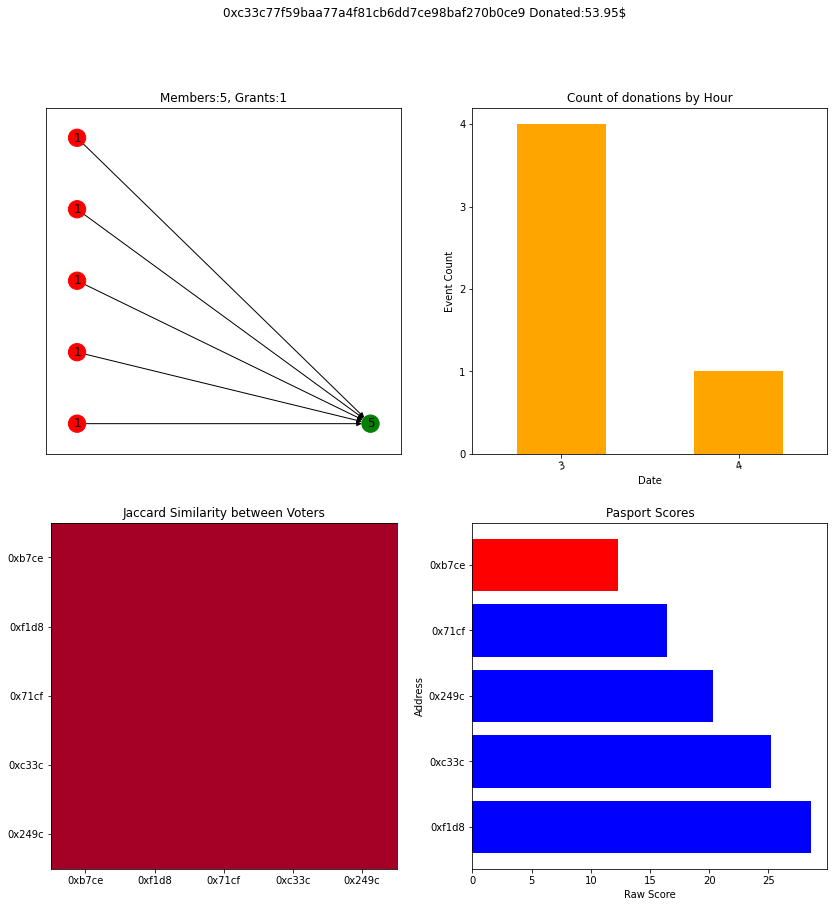

42

In [5]:

small_hop_cluster, *rest = visualize_hop_cluster(HOP_CLUSTERS, DONATIONS, vote_graph, '0xc33c77f59baa77a4f81cb6dd7ce98baf270b0ce9')
#visualize_hop_cluster(HOP_CLUSTERS, DONATIONS, vote_graph, '0x696d181a7961ee66c42f1ebeddc0b48b106c45ad')
42

Finding five addresses that transacted with same grant, on same day we can manually search for similarities between donations. Quick look uncovers high degree of similarity between donations and amounts. 

In [6]:
sus = DONATIONS[DONATIONS['voter'].isin(small_hop_cluster)]

sus[['voter','amountUSD','createdAt']]



,voter,amountUSD,createdAt
23621,0xf1d82cf1e2e23f7bed3af2b3e717d35ffb4cdc38,11.483769,2023-04-29 03:04:47
23701,0xc33c77f59baa77a4f81cb6dd7ce98baf270b0ce9,10.526788,2023-04-29 03:13:11
23717,0x249ca6de88676f0fbf2eea257758a302bfc1ab56,10.335392,2023-04-29 03:16:11
23771,0x71cf7c81f3a3b1bfbf0f3a22340b7ac0b3399bd4,10.718184,2023-04-29 03:32:11
23912,0xb7ce368a08d06b54352c2bef09dea0cdc066b2a1,10.890607,2023-04-29 04:17:47


To conclude for this subset:

- 5 members of same alleged Hop cluster
- sent transactions within span of an hour
- with very similar donation amounts
- to exact same grant

Still, it is only one donation per voter so will do better by finding more interesting group.

0x696d181a7961ee66c42f1ebeddc0b48b106c45ad number voters:
Voters: {'0xde88d146f61463d582262a1dcdf6ea1323aba34a', '0x1ac81fdcd10b27d2af73ef0f097159cdf0f0aa8a', '0x696d181a7961ee66c42f1ebeddc0b48b106c45ad', '0xa1cad48e9844d850f066376e1f1e04147b16619e', '0x080a75c96bf646cd9f78aaf8c9869a510e9c68bb', '0x64b5f9dd6f23269b966a4c3717e150a6dd264851', '0xcf8e24538e6e8c6d7ca711f84539aeac0892e28b', '0x12cd3dca194161fe3535755075499f115982ee63', '0x6d25a1e9e176ab058e0f19e67bcbcaac2be96fa9', '0xbb7bb43af885549f1bbf5724213ee48b40ebee83', '0x597fc897b6ab221c18cf51a31cef41285597aef1', '0xb8a9c37240e8b72f42a88f1099e6c61dc3e96756', '0x9c72c98535224c3c045a3d27ff981ed5a1d64d6e', '0xcd5c1bb777c937d993bc5e16e48b1669becc77aa', '0xcd75942b66c1a82d7e04f65a34ce7f93791fa8a8', '0x335d2d954cec61cb4673780300d890340a29dd99', '0x5cfc2c648ba36144644758f8d39553c0ce355fc6', '0xf20bb1ea28a496db525efbad28a23003c9d73724', '0x939bac3bad78752763be4dd1da19e8e70995a408', '0x91f7c7dc5a44276482c102178fe1d620b397c276', '0xbcc7e64d6b

/tmp/ipykernel_6987/1138747285.py:131: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(short_labels)


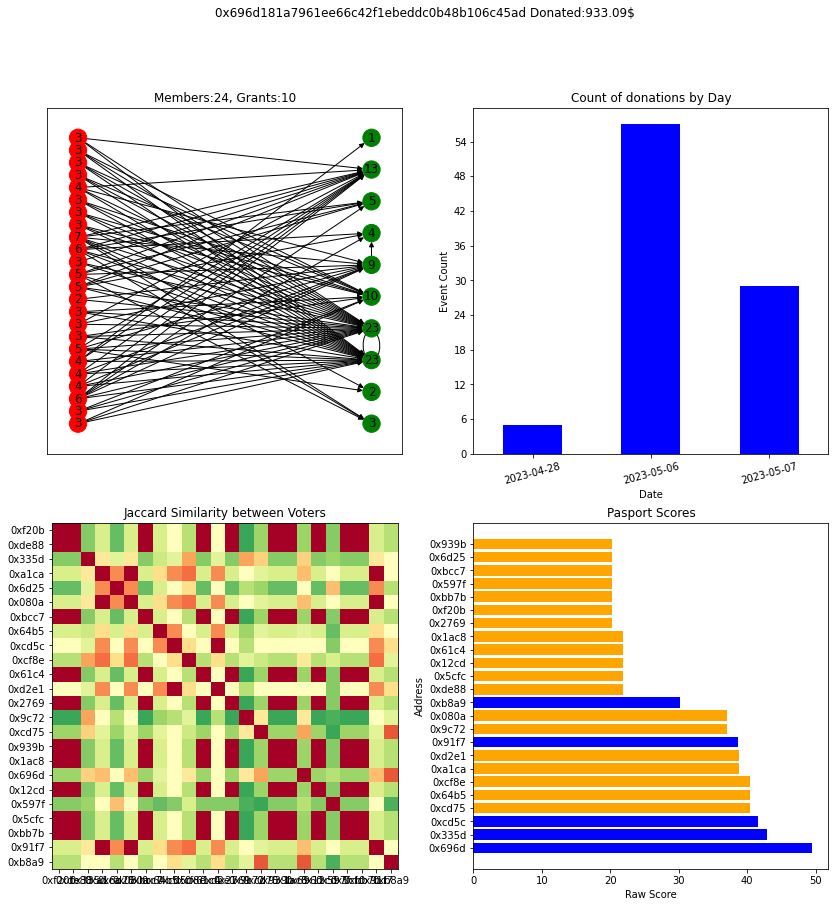

42

In [7]:
visualize_hop_cluster(HOP_CLUSTERS, DONATIONS, vote_graph, '0x696d181a7961ee66c42f1ebeddc0b48b106c45ad')

42

This group is interesting because according to Hop it contained 34 eliminated sybils, and according to Gitcoin 24 addresses from that list participated in current round.

# Interesting Clusters

We may want to look at summary statistics of each suspected sybil group marked by Hop Airdrop. 

-  `hop_size` number of addresses eliminated from airdrop.
- `gitcoin_size` number of addresses in this group currently active in current Gitcoin round.
- Based on previous analysis we found `24/34` group and `5/12` groups interesting. 

In [8]:
HOP_CLUSTERS[['hop_sybil_cluster','gitcoin_size','hop_size', 'ratio']]

,hop_sybil_cluster,gitcoin_size,hop_size,ratio
0,0x696d181a7961ee66c42f1ebeddc0b48b106c45ad,24,34,71.0
1,0xc50eaaee441566b4ef4f1e3270d19f24223cddf4,6,7423,0.0
2,0x236884bb674067c96fcbcc5dff728141e05be99d,6,9,67.0
3,0xd5688734ce9eaa87f640fd81af38f46a49eb1556,6,89,7.0
4,0xc33c77f59baa77a4f81cb6dd7ce98baf270b0ce9,5,12,42.0
5,0x5d0208796bdcb2efabb0acd80b0008becce1d7d5,3,25,12.0
6,0x2e39a66cd137ef1533d0e779332515a45d3aec86,2,48,4.0
7,0xa1a670d5fcd74dd496a93644c11eb750b18e1526,1,13,8.0
8,0x1e5242669ccaabe430398074a507675bbe680996,1,8,12.0
9,0x4ac9995cda14eae44a0811609aa17626e5b727a5,1,13,8.0


Figures for all clusters are present at the end of the notebook. Meanwhile let us focus on largest cluster in the set when looking at both size and ratio of active adresses.

0x696d181a7961ee66c42f1ebeddc0b48b106c45ad number voters:
Voters: {'0xde88d146f61463d582262a1dcdf6ea1323aba34a', '0x1ac81fdcd10b27d2af73ef0f097159cdf0f0aa8a', '0x696d181a7961ee66c42f1ebeddc0b48b106c45ad', '0xa1cad48e9844d850f066376e1f1e04147b16619e', '0x080a75c96bf646cd9f78aaf8c9869a510e9c68bb', '0x64b5f9dd6f23269b966a4c3717e150a6dd264851', '0xcf8e24538e6e8c6d7ca711f84539aeac0892e28b', '0x12cd3dca194161fe3535755075499f115982ee63', '0x6d25a1e9e176ab058e0f19e67bcbcaac2be96fa9', '0xbb7bb43af885549f1bbf5724213ee48b40ebee83', '0x597fc897b6ab221c18cf51a31cef41285597aef1', '0xb8a9c37240e8b72f42a88f1099e6c61dc3e96756', '0x9c72c98535224c3c045a3d27ff981ed5a1d64d6e', '0xcd5c1bb777c937d993bc5e16e48b1669becc77aa', '0xcd75942b66c1a82d7e04f65a34ce7f93791fa8a8', '0x335d2d954cec61cb4673780300d890340a29dd99', '0x5cfc2c648ba36144644758f8d39553c0ce355fc6', '0xf20bb1ea28a496db525efbad28a23003c9d73724', '0x939bac3bad78752763be4dd1da19e8e70995a408', '0x91f7c7dc5a44276482c102178fe1d620b397c276', '0xbcc7e64d6b

/tmp/ipykernel_6987/1138747285.py:131: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(short_labels)


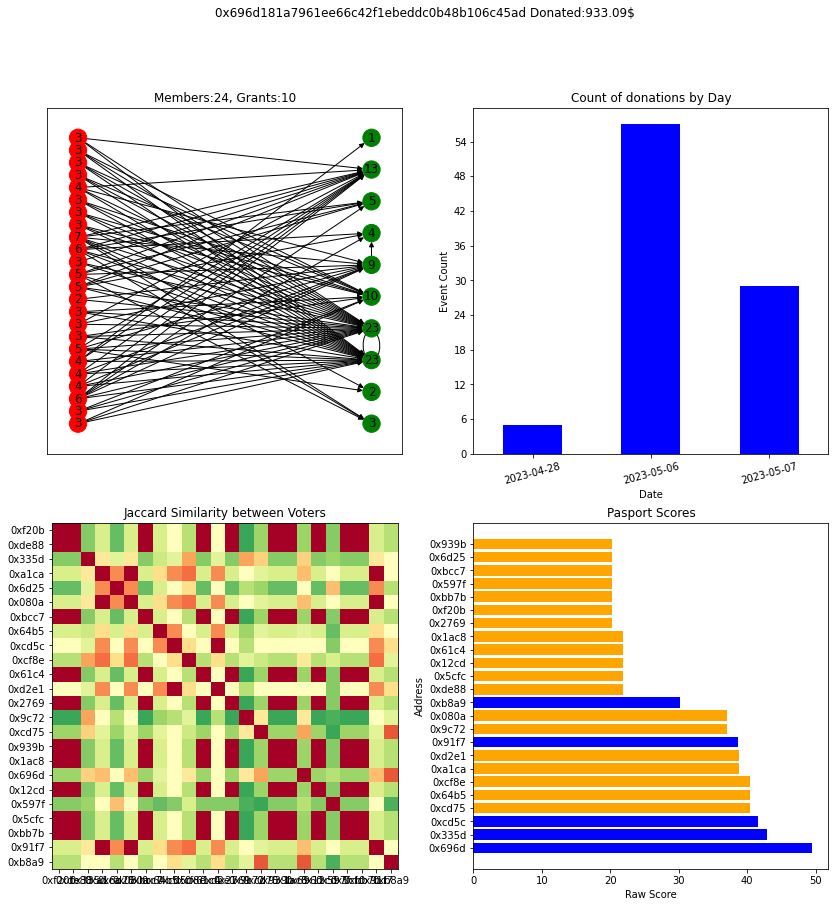

In [9]:

members, jaccards, wallet_scores = visualize_hop_cluster(HOP_CLUSTERS, DONATIONS, vote_graph, '0x696d181a7961ee66c42f1ebeddc0b48b106c45ad')
#print(members,jaccards)

#visualize_cluster(DONATIONS, vote_graph, filtered_items,'Subset')

We see a lot of similarities among wallet scores and donation patterns, we can try drilling it down.

- remove non-unique wallet scores (blue)

wallet scores: [40.46 38.79 37.02 21.9  20.23]

0x696 only non-unique wallet scores number voters:
Voters: {'0xde88d146f61463d582262a1dcdf6ea1323aba34a', '0x1ac81fdcd10b27d2af73ef0f097159cdf0f0aa8a', '0xa1cad48e9844d850f066376e1f1e04147b16619e', '0x080a75c96bf646cd9f78aaf8c9869a510e9c68bb', '0x64b5f9dd6f23269b966a4c3717e150a6dd264851', '0xcf8e24538e6e8c6d7ca711f84539aeac0892e28b', '0x12cd3dca194161fe3535755075499f115982ee63', '0x6d25a1e9e176ab058e0f19e67bcbcaac2be96fa9', '0xbb7bb43af885549f1bbf5724213ee48b40ebee83', '0x597fc897b6ab221c18cf51a31cef41285597aef1', '0x9c72c98535224c3c045a3d27ff981ed5a1d64d6e', '0xcd75942b66c1a82d7e04f65a34ce7f93791fa8a8', '0x5cfc2c648ba36144644758f8d39553c0ce355fc6', '0xf20bb1ea28a496db525efbad28a23003c9d73724', '0x939bac3bad78752763be4dd1da19e8e70995a408', '0xbcc7e64d6b522ef804450000f5bb8d944c7ddd01', '0x27695076ef87e7749ee7ca387f47549ee55dade3', '0x61c4d254051cdbf86dc71d13070a1b6e9abc2489', '0xd2e1b76f81b71304daceec93f7d55d0a2abe2307'}
Grants: {'0x01d79b

/tmp/ipykernel_6987/1138747285.py:131: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(short_labels)


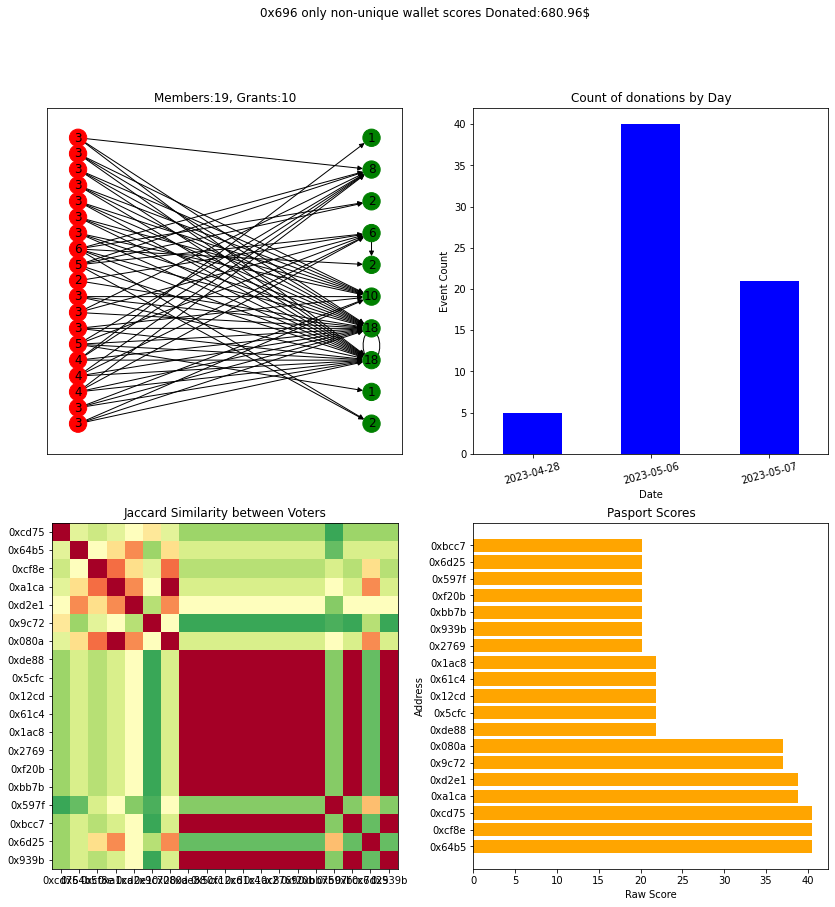

32

In [10]:
non_unique_wallet_scores = wallet_scores[wallet_scores.duplicated(subset='rawScore', keep=False)]
print('wallet scores:',non_unique_wallet_scores.rawScore.unique())
print()
visualize_cluster(DONATIONS, vote_graph, list(non_unique_wallet_scores.address),group_name= '0x696 only non-unique wallet scores')

32

As set becomes smaller, we stumble upon interesting pattern, Jaccard tells us there is a lot of in-group similarity.

- Segment this subset by unique passport scores.

So for each unique passport score in the observed cluster, we will draw a graph containing only voters with that exact passport score.

Cluster Segment with Passport Score= 40.46 Subset of 0x696 cluster number voters:
Voters: {'0x64b5f9dd6f23269b966a4c3717e150a6dd264851', '0xcf8e24538e6e8c6d7ca711f84539aeac0892e28b', '0xcd75942b66c1a82d7e04f65a34ce7f93791fa8a8'}
Grants: {'0x01d79bceaeaadfb8fd2f2f53005289cfcf483464', '0x8110d1d04ac316fdcace8f24fd60c86b810ab15a', '0xeed99e93e073c092131c245c3fda23781563d67d', '0x3a5bd1e37b099ae3386d13947b6a90d97675e5e3', '0x99b36fdbc582d113af36a21eba06bfeab7b9be12', '0xe126b3e5d052f1f575828f61feba4f4f2603652a', '0x57ea12a3a8e441f5fe7b1f3af1121097b7d3b6a8', '0x18aa467e40e1defb1956708830a343c1d01d3d7c', '0xdb0c831283c003686aef40ca228e42bdabf6674c'}


/tmp/ipykernel_6987/1138747285.py:131: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(short_labels)


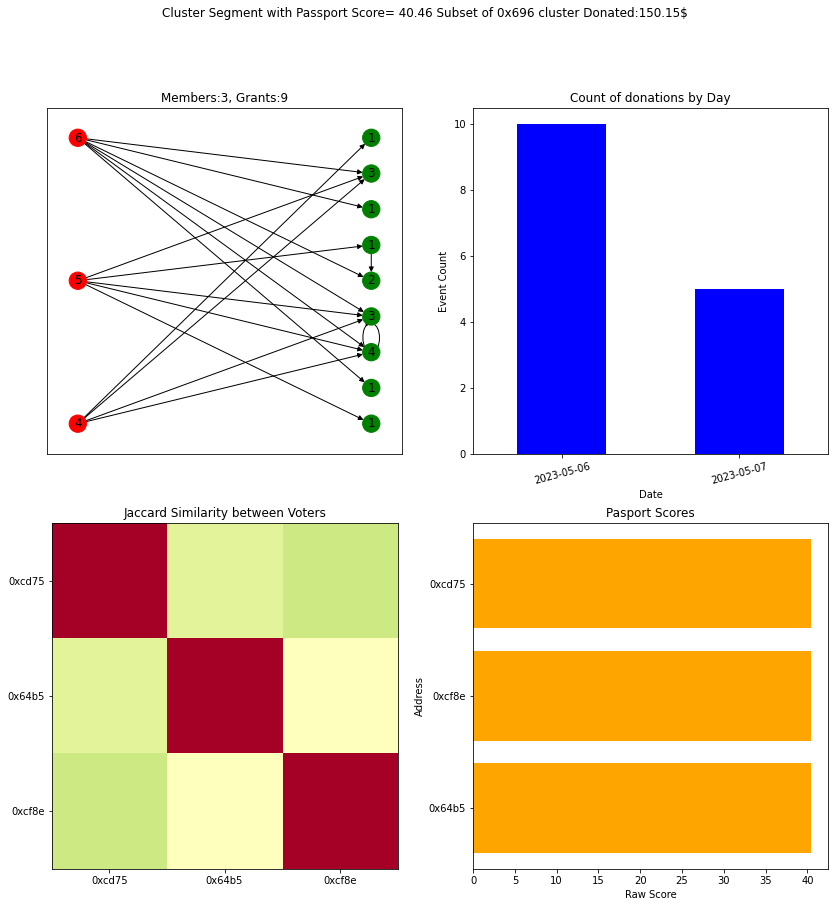

Cluster Segment with Passport Score= 38.79 Subset of 0x696 cluster number voters:
Voters: {'0xa1cad48e9844d850f066376e1f1e04147b16619e', '0xd2e1b76f81b71304daceec93f7d55d0a2abe2307'}
Grants: {'0x3a5bd1e37b099ae3386d13947b6a90d97675e5e3', '0x18aa467e40e1defb1956708830a343c1d01d3d7c', '0x01d79bceaeaadfb8fd2f2f53005289cfcf483464', '0xe126b3e5d052f1f575828f61feba4f4f2603652a'}


/tmp/ipykernel_6987/1138747285.py:131: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(short_labels)


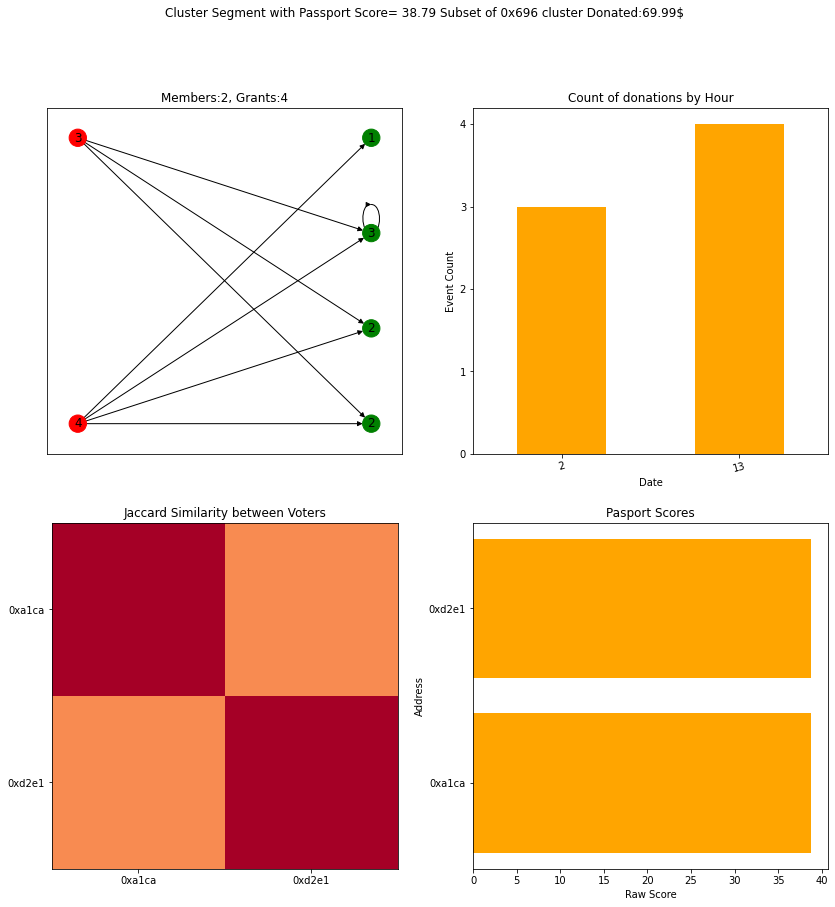

Cluster Segment with Passport Score= 37.02 Subset of 0x696 cluster number voters:
Voters: {'0x9c72c98535224c3c045a3d27ff981ed5a1d64d6e', '0x080a75c96bf646cd9f78aaf8c9869a510e9c68bb'}
Grants: {'0x01d79bceaeaadfb8fd2f2f53005289cfcf483464', '0x8110d1d04ac316fdcace8f24fd60c86b810ab15a', '0x3a5bd1e37b099ae3386d13947b6a90d97675e5e3', '0xe126b3e5d052f1f575828f61feba4f4f2603652a', '0x57ea12a3a8e441f5fe7b1f3af1121097b7d3b6a8', '0x18aa467e40e1defb1956708830a343c1d01d3d7c'}


/tmp/ipykernel_6987/1138747285.py:131: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(short_labels)


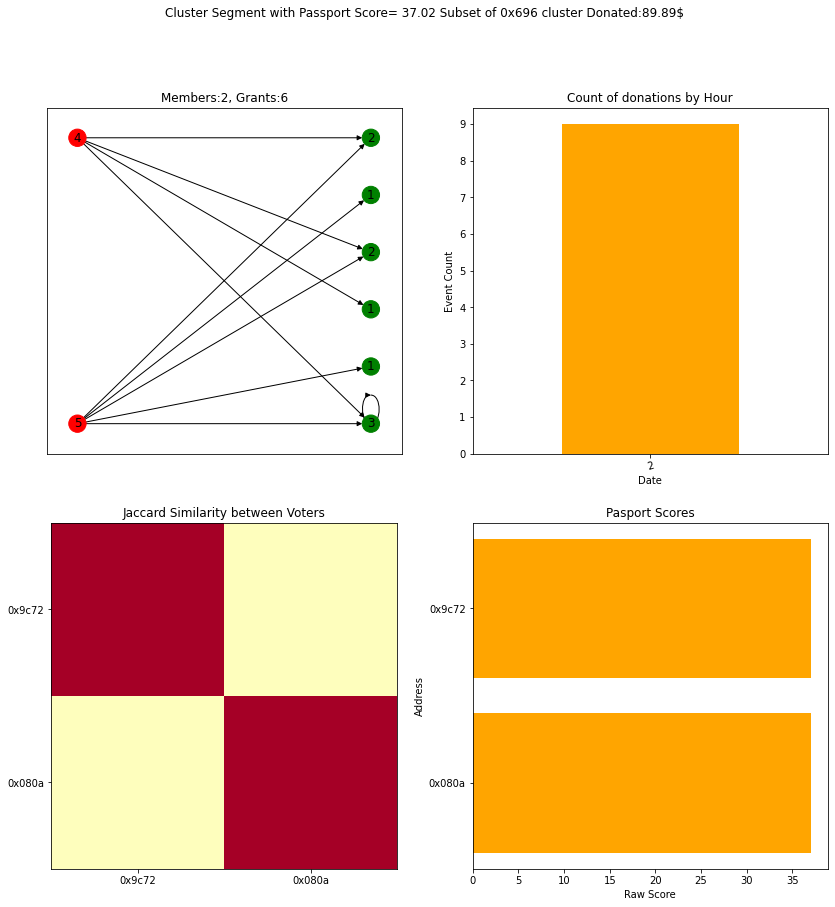

Cluster Segment with Passport Score= 21.9 Subset of 0x696 cluster number voters:
Voters: {'0x61c4d254051cdbf86dc71d13070a1b6e9abc2489', '0xde88d146f61463d582262a1dcdf6ea1323aba34a', '0x1ac81fdcd10b27d2af73ef0f097159cdf0f0aa8a', '0x12cd3dca194161fe3535755075499f115982ee63', '0x5cfc2c648ba36144644758f8d39553c0ce355fc6'}
Grants: {'0x3a5bd1e37b099ae3386d13947b6a90d97675e5e3', '0x01d79bceaeaadfb8fd2f2f53005289cfcf483464', '0x7a0857d314f62d383341b4ed8fe380e7c98fb978'}


/tmp/ipykernel_6987/1138747285.py:131: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(short_labels)


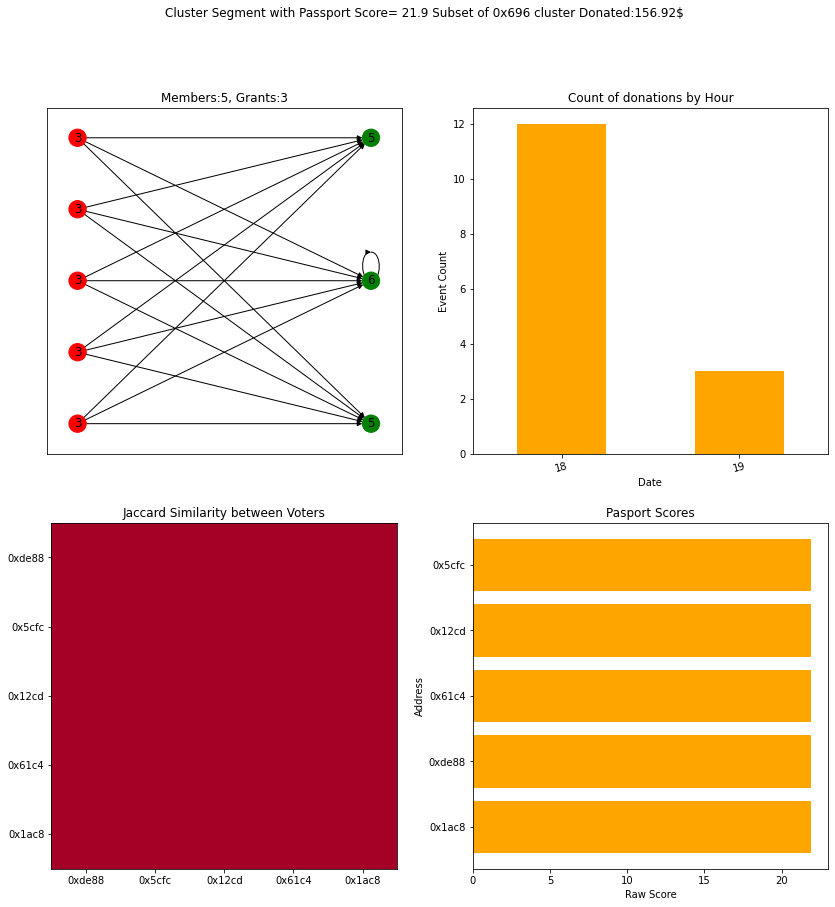

Cluster Segment with Passport Score= 20.23 Subset of 0x696 cluster number voters:
Voters: {'0xbcc7e64d6b522ef804450000f5bb8d944c7ddd01', '0x6d25a1e9e176ab058e0f19e67bcbcaac2be96fa9', '0x27695076ef87e7749ee7ca387f47549ee55dade3', '0xf20bb1ea28a496db525efbad28a23003c9d73724', '0xbb7bb43af885549f1bbf5724213ee48b40ebee83', '0x597fc897b6ab221c18cf51a31cef41285597aef1', '0x939bac3bad78752763be4dd1da19e8e70995a408'}
Grants: {'0x01d79bceaeaadfb8fd2f2f53005289cfcf483464', '0x3a5bd1e37b099ae3386d13947b6a90d97675e5e3', '0x7a0857d314f62d383341b4ed8fe380e7c98fb978', '0xe126b3e5d052f1f575828f61feba4f4f2603652a', '0x18aa467e40e1defb1956708830a343c1d01d3d7c'}


/tmp/ipykernel_6987/1138747285.py:131: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(short_labels)


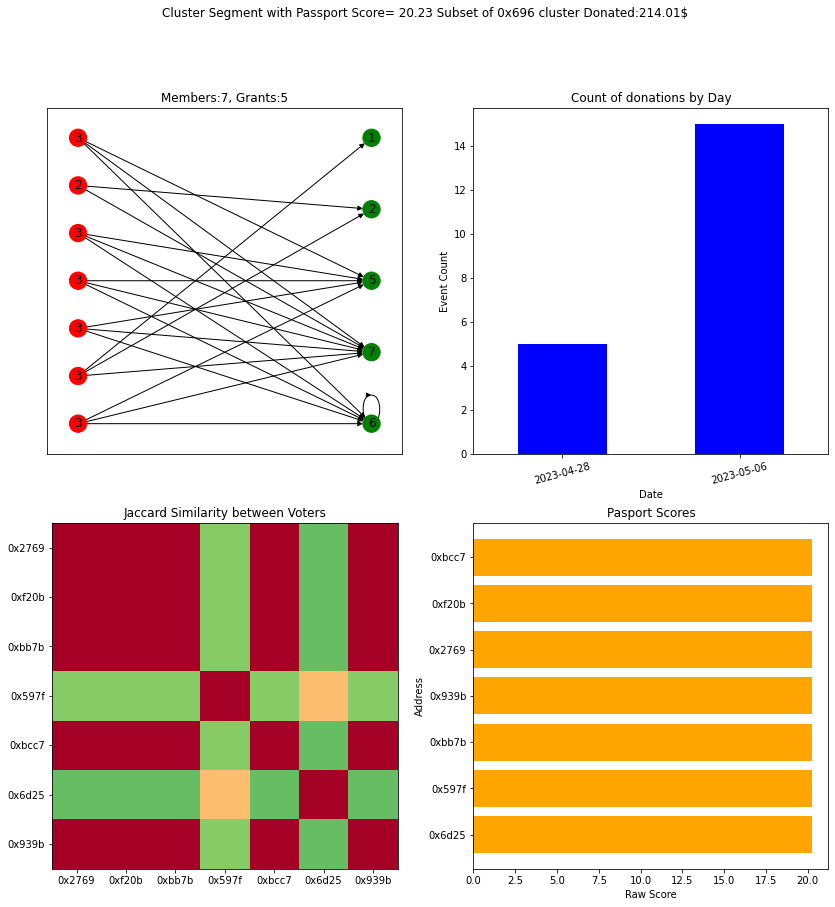

In [14]:
# We should keep drilling down.
unique_wallet_scores = list(non_unique_wallet_scores['rawScore'].unique())
for score in unique_wallet_scores:
    subset = non_unique_wallet_scores[non_unique_wallet_scores['rawScore'] == score] # Consider fuzzy matching?
    last, *rest = visualize_cluster(DONATIONS, vote_graph, list(subset.address), f'Cluster Segment with Passport Score= {score} Subset of 0x696 cluster')

#about_20 = non_unique_wallet_scores[non_unique_wallet_scores['rawScore'] == 20.23] # Consider fuzzy matching(?)
#m,j,p = visualize_cluster(DONATIONS, vote_graph, list(about_20.address),'Subset')
#def helper()


In [15]:
# For the last cluster we have seen we can list all transactions, segmented by day.
# all show remarkably similar pattern.

sus = DONATIONS[DONATIONS['voter'].isin(last)]
#From temporal data and amounts we can find two-sub-groups of addresses with almost exact same activity when it comes to donating.
sus[['voter','amountUSD','createdAt','transaction']].groupby(sus.createdAt.dt.day).apply(display)


,voter,amountUSD,createdAt,transaction
33553,0x27695076ef87e7749ee7ca387f47549ee55dade3,10.461456,2023-05-06 18:47:47,0xd7fceef168ce0de7e77991924fb0ee5c4ec388e52038...
33554,0x27695076ef87e7749ee7ca387f47549ee55dade3,10.461456,2023-05-06 18:47:47,0xd7fceef168ce0de7e77991924fb0ee5c4ec388e52038...
33555,0x27695076ef87e7749ee7ca387f47549ee55dade3,10.461456,2023-05-06 18:47:47,0xd7fceef168ce0de7e77991924fb0ee5c4ec388e52038...
33595,0x939bac3bad78752763be4dd1da19e8e70995a408,10.461456,2023-05-06 18:55:23,0x5eaa47f5503c35a2aade1eeb0083958b6b032bf25c44...
33596,0x939bac3bad78752763be4dd1da19e8e70995a408,10.461456,2023-05-06 18:55:23,0x5eaa47f5503c35a2aade1eeb0083958b6b032bf25c44...
33597,0x939bac3bad78752763be4dd1da19e8e70995a408,10.461456,2023-05-06 18:55:23,0x5eaa47f5503c35a2aade1eeb0083958b6b032bf25c44...
33622,0xbb7bb43af885549f1bbf5724213ee48b40ebee83,10.461456,2023-05-06 19:00:11,0xa8b7a316f44193c3b1419580a9769581fd61809101bf...
33623,0xbb7bb43af885549f1bbf5724213ee48b40ebee83,10.461456,2023-05-06 19:00:11,0xa8b7a316f44193c3b1419580a9769581fd61809101bf...
33624,0xbb7bb43af885549f1bbf5724213ee48b40ebee83,10.461456,2023-05-06 19:00:11,0xa8b7a316f44193c3b1419580a9769581fd61809101bf...
33625,0xbcc7e64d6b522ef804450000f5bb8d944c7ddd01,10.461456,2023-05-06 19:00:23,0x6e64e0ddffdfe5876140a99180ebd867663a164afeae...


,voter,amountUSD,createdAt,transaction
19906,0x597fc897b6ab221c18cf51a31cef41285597aef1,11.418239,2023-04-28 01:33:23,0x09e3a3929403cafd1c99b2c8a999fa390ad3bb4cf5f9...
19907,0x597fc897b6ab221c18cf51a31cef41285597aef1,11.418239,2023-04-28 01:33:23,0x09e3a3929403cafd1c99b2c8a999fa390ad3bb4cf5f9...
19924,0x6d25a1e9e176ab058e0f19e67bcbcaac2be96fa9,11.418239,2023-04-28 01:38:59,0x66e398623dd789e046143f6535228edaddb697944506...
19925,0x6d25a1e9e176ab058e0f19e67bcbcaac2be96fa9,11.418239,2023-04-28 01:38:59,0x66e398623dd789e046143f6535228edaddb697944506...
19926,0x6d25a1e9e176ab058e0f19e67bcbcaac2be96fa9,11.418239,2023-04-28 01:38:59,0x66e398623dd789e046143f6535228edaddb697944506...


""


In the passport scores we just drawn, there was a one cluster segment where each member was exactly similar to other members when it comes to donations.

sus number voters:
Voters: {'0x61c4d254051cdbf86dc71d13070a1b6e9abc2489', '0xde88d146f61463d582262a1dcdf6ea1323aba34a', '0x1ac81fdcd10b27d2af73ef0f097159cdf0f0aa8a', '0x12cd3dca194161fe3535755075499f115982ee63', '0x5cfc2c648ba36144644758f8d39553c0ce355fc6'}
Grants: {'0x3a5bd1e37b099ae3386d13947b6a90d97675e5e3', '0x01d79bceaeaadfb8fd2f2f53005289cfcf483464', '0x7a0857d314f62d383341b4ed8fe380e7c98fb978'}


/tmp/ipykernel_6987/1138747285.py:131: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(short_labels)


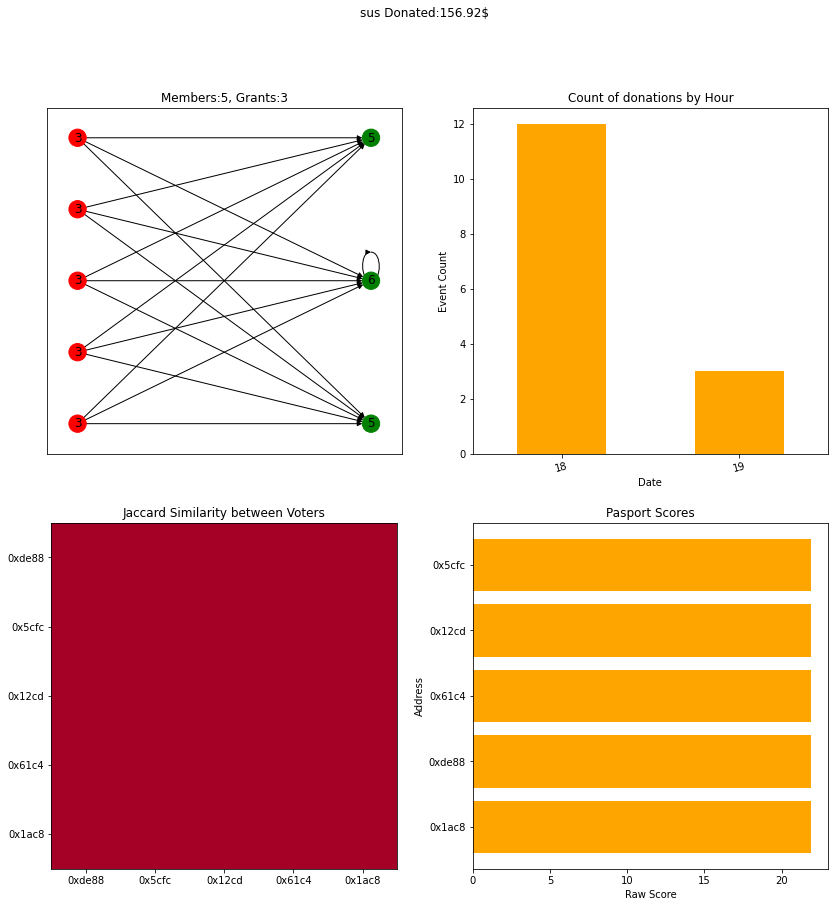

In [16]:
#Once again visualize the most interesting cluster, where we did not 
about_20 = non_unique_wallet_scores[non_unique_wallet_scores['rawScore'] == 21.9] # Consider fuzzy matching(?)
m,j,p = visualize_cluster(DONATIONS, vote_graph, list(about_20.address),'sus')


This cluster segment looks really interesting, as before we should take a look at all donations that ocurred here.

In [ ]:


sus = DONATIONS[DONATIONS['voter'].isin(m)]
#From temporal data and amounts we can find two-sub-groups of addresses with almost exact same activity when it comes to donating.
sus[['voter','amountUSD','createdAt','transaction']].groupby(sus.createdAt.dt.day).apply(display)

,voter,amountUSD,createdAt,transaction
33415,0xde88d146f61463d582262a1dcdf6ea1323aba34a,10.461456,2023-05-06 18:13:35,0x9ea9730924330ba55fa9bbaf327b7df11b7b3fb2237d...
33416,0xde88d146f61463d582262a1dcdf6ea1323aba34a,10.461456,2023-05-06 18:13:35,0x9ea9730924330ba55fa9bbaf327b7df11b7b3fb2237d...
33417,0xde88d146f61463d582262a1dcdf6ea1323aba34a,10.461456,2023-05-06 18:13:35,0x9ea9730924330ba55fa9bbaf327b7df11b7b3fb2237d...
33544,0x12cd3dca194161fe3535755075499f115982ee63,10.461456,2023-05-06 18:42:47,0x09eb484eff0210140ea9df3638529b5094ab5eeec29f...
33545,0x12cd3dca194161fe3535755075499f115982ee63,10.461456,2023-05-06 18:42:47,0x09eb484eff0210140ea9df3638529b5094ab5eeec29f...
33546,0x12cd3dca194161fe3535755075499f115982ee63,10.461456,2023-05-06 18:42:47,0x09eb484eff0210140ea9df3638529b5094ab5eeec29f...
33558,0x5cfc2c648ba36144644758f8d39553c0ce355fc6,10.461456,2023-05-06 18:47:47,0x9b059ed87d9d17f5d6486184a742bccb177e25a3d8c0...
33559,0x5cfc2c648ba36144644758f8d39553c0ce355fc6,10.461456,2023-05-06 18:47:47,0x9b059ed87d9d17f5d6486184a742bccb177e25a3d8c0...
33560,0x5cfc2c648ba36144644758f8d39553c0ce355fc6,10.461456,2023-05-06 18:47:47,0x9b059ed87d9d17f5d6486184a742bccb177e25a3d8c0...
33611,0x1ac81fdcd10b27d2af73ef0f097159cdf0f0aa8a,10.461456,2023-05-06 18:57:35,0x47ec2a728666121a0f1107b792f460a80b5de85fbff8...


""


Looking at amounts donated to exactly same grants and time it starts to look like coordinated behaviour for this particular sub-group of wallets.

# Drawing active Hop Clusters

This concludes analysis and findings for two most interesting clusters. Below I introduce all other Hop Clusters with >1 member active in Gitcoin Beta round.

0x696d181a7961ee66c42f1ebeddc0b48b106c45ad number voters:
Voters: {'0x61c4d254051cdbf86dc71d13070a1b6e9abc2489', '0xde88d146f61463d582262a1dcdf6ea1323aba34a', '0x6d25a1e9e176ab058e0f19e67bcbcaac2be96fa9', '0xcd75942b66c1a82d7e04f65a34ce7f93791fa8a8', '0xb8a9c37240e8b72f42a88f1099e6c61dc3e96756', '0xd2e1b76f81b71304daceec93f7d55d0a2abe2307', '0x597fc897b6ab221c18cf51a31cef41285597aef1', '0x5cfc2c648ba36144644758f8d39553c0ce355fc6', '0x939bac3bad78752763be4dd1da19e8e70995a408', '0x080a75c96bf646cd9f78aaf8c9869a510e9c68bb', '0xa1cad48e9844d850f066376e1f1e04147b16619e', '0x27695076ef87e7749ee7ca387f47549ee55dade3', '0x335d2d954cec61cb4673780300d890340a29dd99', '0x12cd3dca194161fe3535755075499f115982ee63', '0x696d181a7961ee66c42f1ebeddc0b48b106c45ad', '0xbb7bb43af885549f1bbf5724213ee48b40ebee83', '0xf20bb1ea28a496db525efbad28a23003c9d73724', '0x91f7c7dc5a44276482c102178fe1d620b397c276', '0x1ac81fdcd10b27d2af73ef0f097159cdf0f0aa8a', '0xcf8e24538e6e8c6d7ca711f84539aeac0892e28b', '0x64b5f9dd6f

/tmp/ipykernel_2416/1138747285.py:131: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(short_labels)


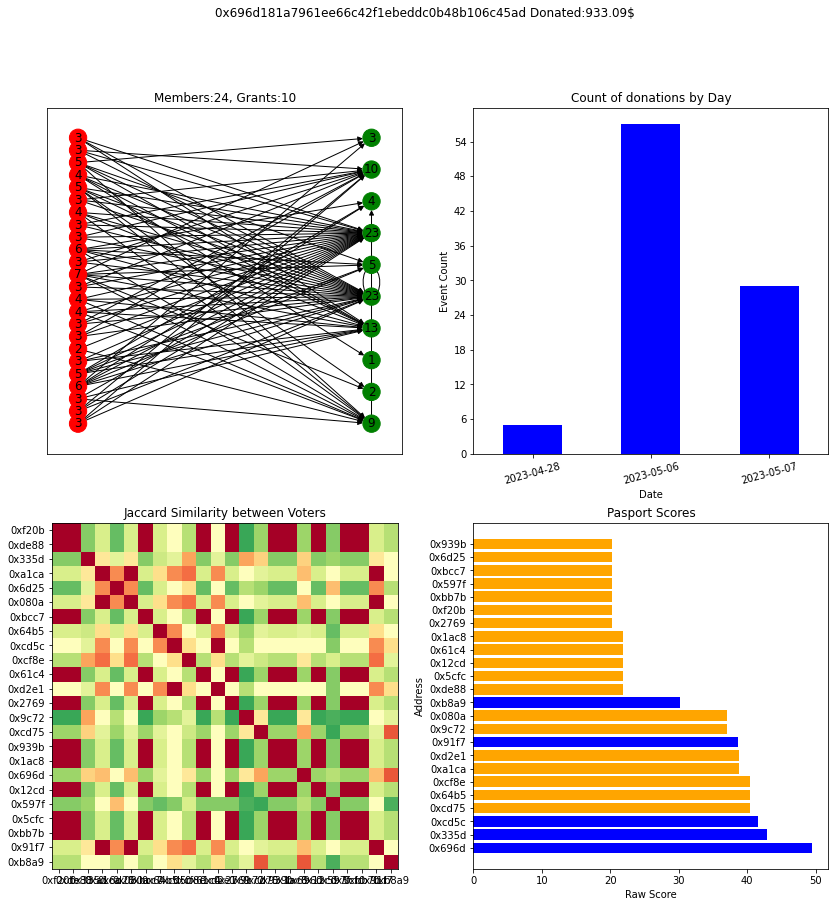

0xc50eaaee441566b4ef4f1e3270d19f24223cddf4 number voters:
Voters: {'0x3082f27581a2449268a14af56d810cacd9984ec1', '0xaa6c7b556449e1d5a75b6322a256180edd1c8edc', '0xce4752074d68fddf215b403417baa90fef31bba8', '0x600f9faa8a2d39a710b28e2d0ec8a5dacc12b00f', '0x90ff89c637fd1537e151b8ced1d1d0cb94e31ca6', '0x88dbfc20d2f2bc004d4dde1947deda4cd478dd0d'}
Grants: {'0xe126b3e5d052f1f575828f61feba4f4f2603652a', '0x7e41de88c46d9fb24547d01f9d396e7d2d15cc14', '0x4d9339dd97db55e3b9bcbe65de39ff9c04d1c2cd', '0x12e838f846ffdade34b2e006f84117a370d71687', '0x33359285f30e7b3386de70ca500f4fe27853765b', '0x4af147188bfe1c02d18d752ed5e473d8394f2300', '0xfda84cfc7d83d9d744590280289160f8118966e5', '0x850a146d7478daaa98fc26fd85e6a24e50846a9d', '0x5683921269b041fbe66882dd6cadd48b7e5b5817', '0xeb439eed5642641968f9d8b52f2788e0f19b443b', '0x18aa467e40e1defb1956708830a343c1d01d3d7c', '0xf4a96d0025717b37252dce516e33541eadcf1e70', '0x7d658841f8ba93299970f6e765c2ce205f1e70dd', '0xbbbb17a8c1ce64be28facd93b22450abb01b5dca', '0x1

/tmp/ipykernel_2416/1138747285.py:131: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(short_labels)


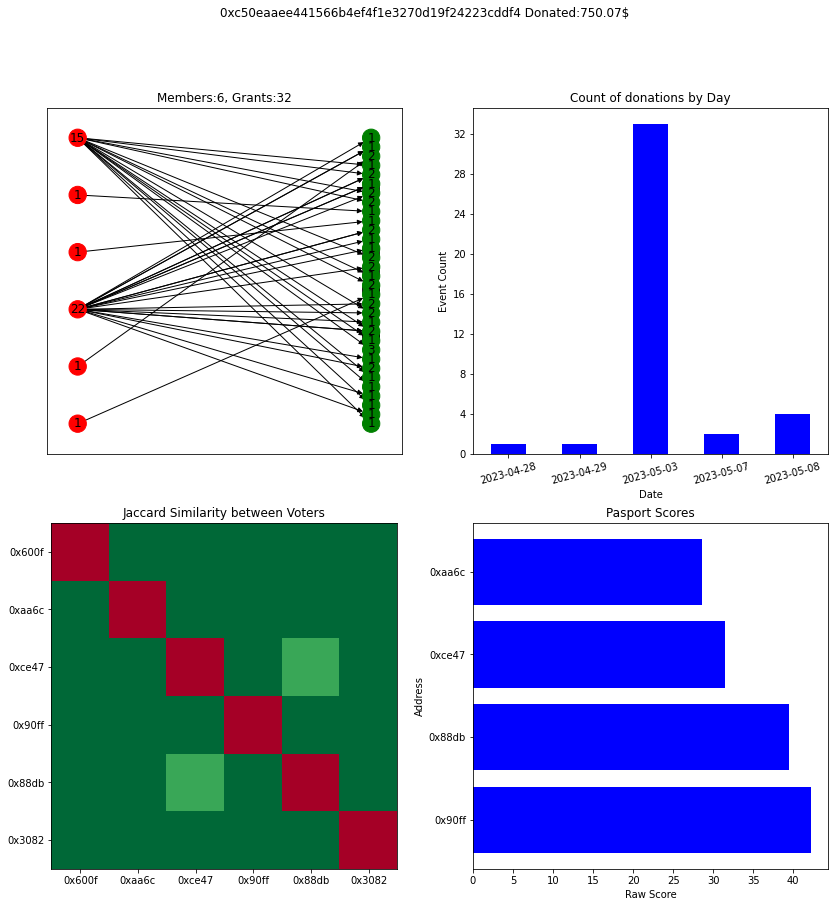

0x236884bb674067c96fcbcc5dff728141e05be99d number voters:
Voters: {'0x236884bb674067c96fcbcc5dff728141e05be99d', '0x05ac3d28434804ec02ed9472490fc42d7e9e646d', '0xe1d1c5f48f708aa038aa6a9976308cd1d19d951a', '0xf977bf5f5ccb1bfd868bd95d563294494f0d5d89', '0xdd4a19dc351ba42421db282196af38b433aa86ba', '0x9497243478392b1f7f508874f606379f989c6eea'}
Grants: {'0x8ba1f109551bd432803012645ac136ddd64dba72', '0xe126b3e5d052f1f575828f61feba4f4f2603652a', '0xf29ff96aaea6c9a1fba851f74737f3c069d4f1a9', '0x713bc00d1df5c452f172c317d39eff71b771c163', '0x9cce47e9cf12c6147c9844adbb81fe85880c4df4', '0x18aa467e40e1defb1956708830a343c1d01d3d7c', '0x08a3c2a819e3de7aca384c798269b3ce1cd0e437', '0x242ba6d68ffeb4a098b591b32d370f973ff882b7', '0x3a5bd1e37b099ae3386d13947b6a90d97675e5e3', '0x6c5a2688c83c806150ca9dd0b2f10f16f8f1c33e'}


/tmp/ipykernel_2416/1138747285.py:131: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(short_labels)


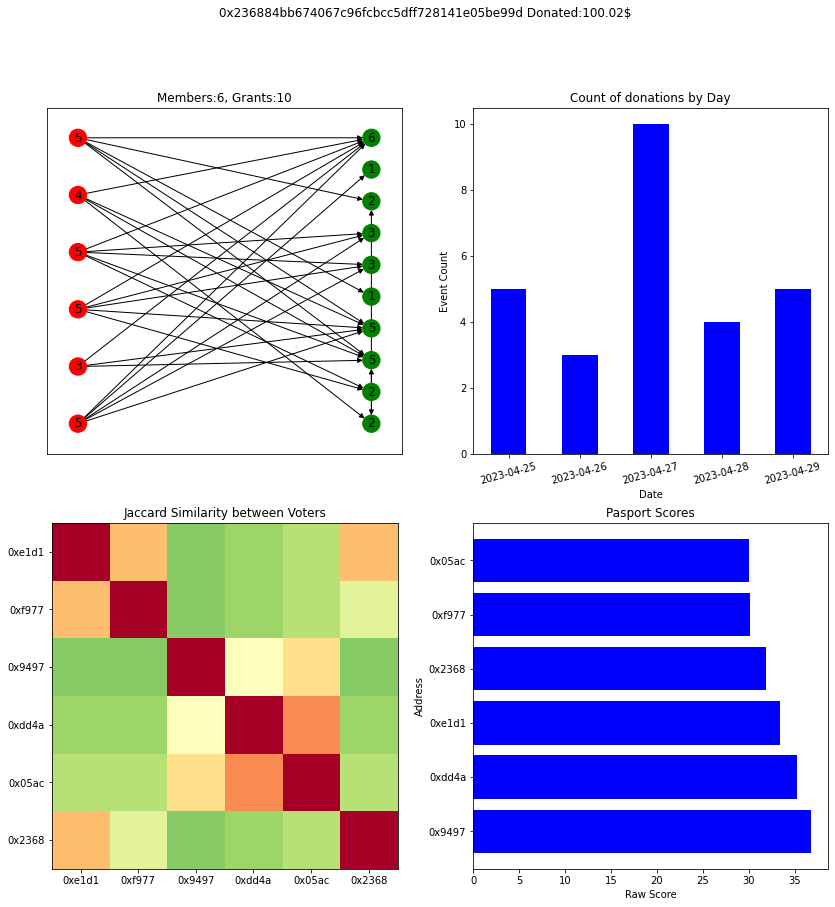

0xd5688734ce9eaa87f640fd81af38f46a49eb1556 number voters:
Voters: {'0xdc23f11f93926fcc94001fb7ea2a955d991fb0f7', '0x83c9f34cf833517a749cc7c4b7f979791f65e640', '0x7caa0c7ba1c1fd309c84d3e9ac4798e03bc16420', '0x42fbb0a6fd3dc64fb2799d911ba2187a2d7b5fcd', '0x38d8f8b47017031da62509b1541990673c1d2ece', '0xe48542fa62206559e5734667064d2c04b6cda2e2'}
Grants: {'0x4b8810b079eb22ecf2d1f75e08e0abbd6fd87dbf', '0x02d1b4658799f61a3a627e12e17c08c59053022f', '0x5afc7720b161788f9d833555b7ebc3274fd98da1', '0x18aa467e40e1defb1956708830a343c1d01d3d7c', '0x01d79bceaeaadfb8fd2f2f53005289cfcf483464', '0x08a3c2a819e3de7aca384c798269b3ce1cd0e437', '0x7bd7de26ebd064465bb9c272513bb3bcbddb1e93', '0x9fc13b4e1c4206970a1c4520d2f77336cd5d0e0a', '0x3a5bd1e37b099ae3386d13947b6a90d97675e5e3', '0x99b36fdbc582d113af36a21eba06bfeab7b9be12', '0xf0dbde527c63b63178576578777f0b7e24755abb'}


/tmp/ipykernel_2416/1138747285.py:131: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(short_labels)


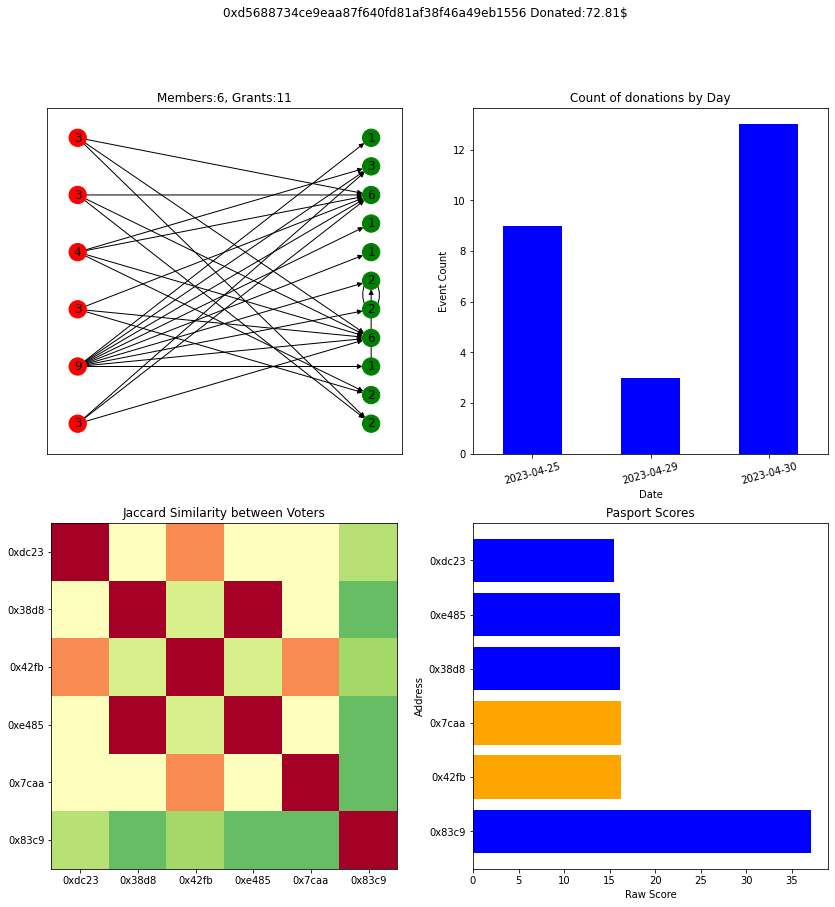

0xc33c77f59baa77a4f81cb6dd7ce98baf270b0ce9 number voters:
Voters: {'0xf1d82cf1e2e23f7bed3af2b3e717d35ffb4cdc38', '0xc33c77f59baa77a4f81cb6dd7ce98baf270b0ce9', '0x249ca6de88676f0fbf2eea257758a302bfc1ab56', '0x71cf7c81f3a3b1bfbf0f3a22340b7ac0b3399bd4', '0xb7ce368a08d06b54352c2bef09dea0cdc066b2a1'}
Grants: {'0x3a5bd1e37b099ae3386d13947b6a90d97675e5e3'}


/tmp/ipykernel_2416/1138747285.py:131: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(short_labels)


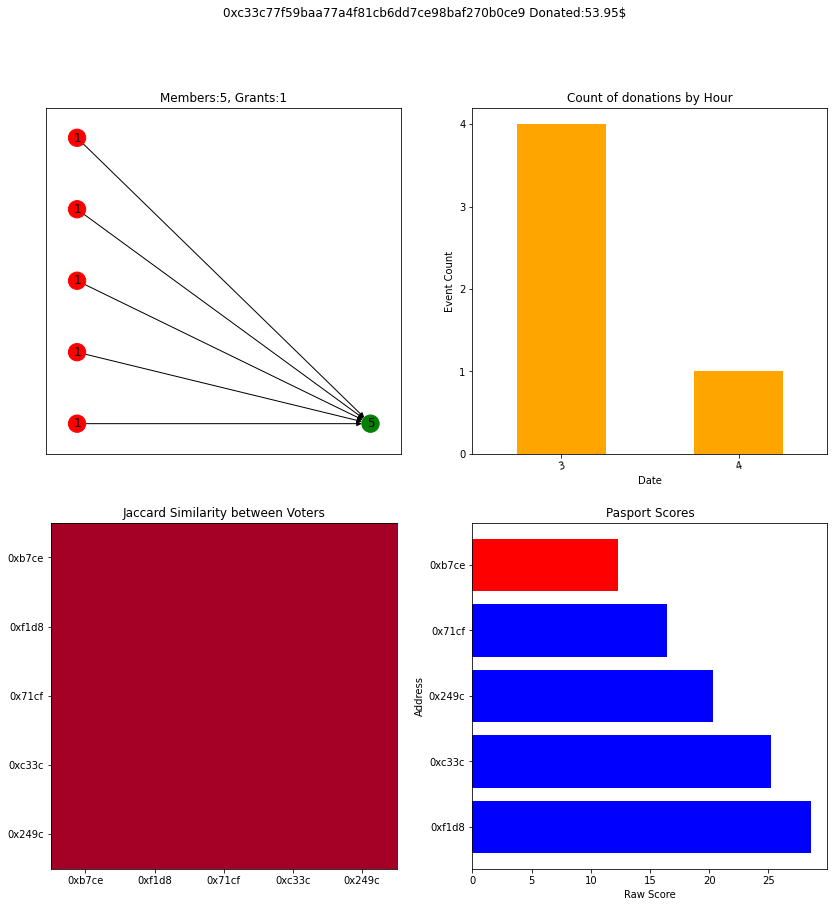

0x5d0208796bdcb2efabb0acd80b0008becce1d7d5 number voters:
Voters: {'0x5d0208796bdcb2efabb0acd80b0008becce1d7d5', '0x6ad899aea96f21c226d63e3c69ac27c25a360876', '0xd21de902fe7ac1acc54dcc1f1bc7dbbf6fe13f0d'}
Grants: {'0x5683921269b041fbe66882dd6cadd48b7e5b5817', '0x08a3c2a819e3de7aca384c798269b3ce1cd0e437'}


/tmp/ipykernel_2416/1138747285.py:131: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(short_labels)


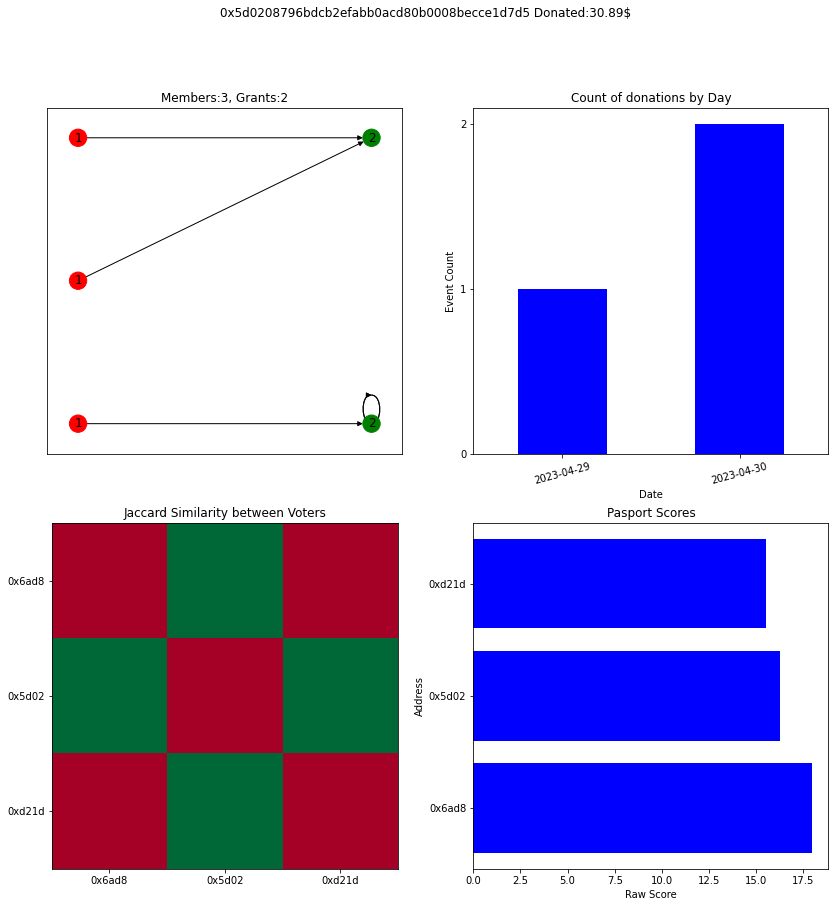

0x2e39a66cd137ef1533d0e779332515a45d3aec86 number voters:
Voters: {'0xe9cb9f9c1749b8c7e80350f58f3fc8efaca9816a', '0x8bea0dfbceb93b0bc774157a6cc6272349ea1ee4'}
Grants: {'0x3a5bd1e37b099ae3386d13947b6a90d97675e5e3'}


/tmp/ipykernel_2416/1138747285.py:131: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(short_labels)


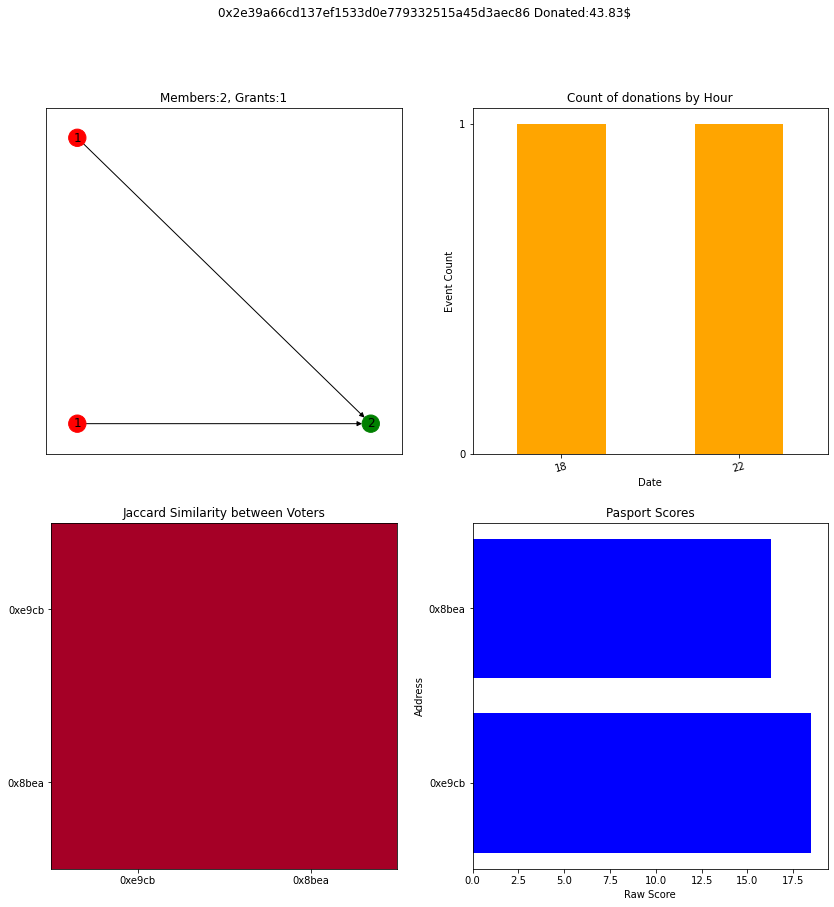

Hop cluster 0xa1a670d5fcd74dd496a93644c11eb750b18e1526 has only [1] members who donated 39.99$
Hop cluster 0x1e5242669ccaabe430398074a507675bbe680996 has only [1] members who donated 64.73$
Hop cluster 0x4ac9995cda14eae44a0811609aa17626e5b727a5 has only [1] members who donated 31.33$
Hop cluster 0x0c70441ab440ecc8ad8772b857e58cf8226f0eb3 has only [1] members who donated 18.0$
Hop cluster 0x9fa7fd8d9170f0dda389922e6c956800d5149924 has only [1] members who donated 38.05$
Hop cluster 0x1ae799f6a41270ed8ba9644dca1ae7f7378d7fcf has only [1] members who donated 36.43$
Hop cluster 0xf89f3336368340bd8a6af2228f4a3d753b7a97a4 has only [1] members who donated 16.61$
Hop cluster 0x4d2ed284cb9ebaab06bc01cc1c7f824e5b161378 has only [1] members who donated 7.06$
Hop cluster 0xe4036aca909cd049f9a7b7333961e1c1db7fb35c has only [1] members who donated 44.25$
Hop cluster 0x644be8a25be30a21e2dffeae4fc43937fbcf3efd has only [1] members who donated 93.99$
Hop cluster 0x166fa71515d188adbf60746b45338c29214db7

42

In [ ]:
interesting_members = []
for cluster_id in HOP_CLUSTERS.hop_sybil_cluster:

    members = visualize_hop_cluster(HOP_CLUSTERS, DONATIONS, vote_graph, cluster_id)

    if members is not None:
        interesting_members = interesting_members + members[0]

# since we are doing so we can grab listing of all interesting cluster members.
interesting_members
42

# Concluding 

Listing of all suspected Sybil clusters according to Hop airdrop round is inside `beta_round_clusters_Hop`.

Most interesting cluster spotted so far bears ID `'0x696d181a7961ee66c42f1ebeddc0b48b106c45ad'` and is responsible for about ~1k USD in pre-matching donations.

Most interesting subset of this cluster with extreme similarity in timing, amount and target of donations can be found by getting subset of `0x606x` with wallet score `21.9`